An example script for using texturegan model

In [1]:
from argparser import parse_arguments

In [2]:
#dummy command
command = '--display_port 7770 --load 0 --load_D -1 --load_epoch 105 --gpu 2 --model texturegan --feature_weight 1e2 --pixel_weight_ab 1e3 --global_pixel_weight_l 1e3 --local_pixel_weight_l 0 --style_weight 0 --discriminator_weight 1e3 --discriminator_local_weight 1e6  --learning_rate 1e-4 --learning_rate_D 1e-4 --batch_size 36 --save_every 50 --num_epoch 100000 --save_dir /home/psangkloy3/skip_leather_re/ --load_dir /home/psangkloy3/skip_leather_re/ --data_path ../../training_handbags_pretrain/ --learning_rate_D_local  1e-4 --local_texture_size 50 --patch_size_min 20 --patch_size_max 40 --num_input_texture_patch 1 --visualize_every 5 --num_local_texture_patch 1'
args = parse_arguments(command.split())


In [28]:
from main import get_transforms
from dataloader import imfol
from dataloader.imfol import ImageFolder, make_dataset
import torch
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader
import math
from torch.autograd import Variable
from utils.visualize import vis_patch, vis_image

## Load from validation folder

In [57]:
args.batch_size = 1
args.image_size =152
args.resize_max = 256
args.resize_min = 256
args.data_path = '/home/psangkloy3/training_handbags_pretrain/'

In [58]:
transform = get_transforms(args)
val = make_dataset(args.data_path, 'val')
valDset = ImageFolder('val', args.data_path, transform)
val_display_size = 1
valLoader = DataLoader(dataset=valDset, batch_size=val_display_size,shuffle=True)

## Load Pretrained model

In [6]:
def load_network(model, save_path):
        
    model_state = torch.load(save_path)
    
    if "state_dict" in model_state:
        model.load_state_dict(model_state["state_dict"])
    else:
        model.load_state_dict(model_state)

        model_state = {
            'state_dict': model.cpu().state_dict(),
            'epoch': epoch,
            'iteration': iteration,
            'model': args.model,
            'color_space': args.color_space,
            'batch_size': args.batch_size,
            'dataset': dataset,
            'image_size': args.image_size
        }
    
    model.cuda()


In [7]:
from models import texturegan,discriminator

netG = texturegan.TextureGAN(5, 3, 32)
load_network(netG, '/home/psangkloy3/texturegan_master/texturegan/best_models/textureD_final_allloss_handbag_3300.pth')

netG.eval()

TextureGAN (
  (model): Sequential (
    (main_model): MainModel (
      (main_model): Sequential (
        (conv_1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
        (norm_1): ReLU (inplace)
        (res_block_1): ResidualBlock (
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU (inplace)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
        )
        (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (batch_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (norm_2): ReLU (inplace)
        (res_block_2): ResidualBlock (
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [11]:
data = valLoader.__iter__().__next__()
from utils import transforms as custom_transforms

In [22]:
def get_input(val_loader,xcenter,ycenter,patch_size,num_patch):
    img, skg, seg, eroded_seg, txt = val_loader
    img = custom_transforms.normalize_lab(img)
    skg = custom_transforms.normalize_lab(skg)
    txt = custom_transforms.normalize_lab(txt)
    seg = custom_transforms.normalize_seg(seg)
    eroded_seg = custom_transforms.normalize_seg(eroded_seg)

    bs, w, h = seg.size()

    seg = seg.view(bs, 1, w, h)
    seg = torch.cat((seg, seg, seg), 1)

    eroded_seg = eroded_seg.view(bs, 1, w, h)
    eroded_seg = torch.cat((eroded_seg, eroded_seg, eroded_seg), 1)

    temp = torch.ones(seg.size()) * (1 - seg).float()
    temp[:, 1, :, :] = 0  # torch.ones(seg[:,1,:,:].size())*(1-seg[:,1,:,:]).float()
    temp[:, 2, :, :] = 0  # torch.ones(seg[:,2,:,:].size())*(1-seg[:,2,:,:]).float()

    txt = txt.float() * seg.float() + temp

    patchsize = args.local_texture_size
    batch_size = bs
    if xcenter < 0 or ycenter < 0:
        inp, texture_loc = gen_input_rand(txt, skg, eroded_seg[:, 0, :, :] * 100,
                                              patch_size, patch_size,
                                              num_patch)
    else:
        inp, texture_loc = gen_input_exact(txt, skg, eroded_seg[:, 0, :, :] * 100,xcenter,ycenter,patch_size,1)
        
    return inp,texture_loc 
def get_inputv(inp):
    input_stack = torch.FloatTensor().cuda()
    input_stack.resize_as_(inp.float()).copy_(inp)
    inputv = Variable(input_stack)
    return inputv

In [19]:
from train import gen_input, rand_between, gen_input_rand

In [31]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np

(-0.5, 151.5, 151.5, -0.5)

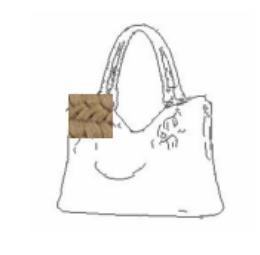

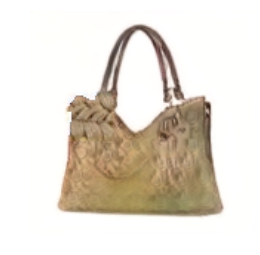

In [94]:
color_space = 'lab'

data = valLoader.__iter__().__next__()

img, skg, seg, eroded_seg, txt = data

img = custom_transforms.normalize_lab(img)
skg = custom_transforms.normalize_lab(skg)
txt = custom_transforms.normalize_lab(txt)
seg = custom_transforms.normalize_seg(seg)
eroded_seg = custom_transforms.normalize_seg(eroded_seg)
inp,texture_loc = get_input(data,-1,-1,30,1)

seg = seg!=0

model = netG

inpv = get_inputv(inp.cuda())
output = model(inpv.cuda())

out_img = vis_image(custom_transforms.denormalize_lab(output.data.double().cpu()),
                                    color_space)
inp_img = vis_patch(custom_transforms.denormalize_lab(txt.cpu()),
                            custom_transforms.denormalize_lab(skg.cpu()),
                            texture_loc,
                            color_space)
tar_img = vis_image(custom_transforms.denormalize_lab(img.cpu()),
                        color_space)

plt.figure()
plt.imshow(np.transpose(inp_img[0],(1, 2, 0)))
plt.axis('off')
#plt.figure()  
plt.figure()
plt.imshow(np.transpose(out_img[0],(1, 2, 0)))
plt.axis('off')